In [27]:
# --- Setup: Make repo importable ---
import sys
from pathlib import Path

REPO_ROOT = Path("..").resolve()
if str(REPO_ROOT) not in sys.path:
    sys.path.append(str(REPO_ROOT))
print("repo root:", REPO_ROOT)

repo root: C:\Users\ruzgh\PycharmProjects\pixelart-ccgen


In [28]:
# --- Config ---
RUN_DOWNLOAD = True  # set False to skip download step
DATASET_SLUG = "ebrahimelgazar/pixel-art"  # Kaggle slug (owner/dataset)
RAW_DIR = Path("../data/raw")
CSV_PATH = RAW_DIR / "labels.csv"
CACHE_DIR = Path("../data/_cache")
OUT_INDEX = CACHE_DIR / "dataset_index.csv"
OUT_MAP = CACHE_DIR / "class_to_idx.json"

SAMPLES_PER_CLASS = 6
MAX_CLASSES_TO_SHOW = 6

In [29]:
# --- Imports ---
import re, json
import pandas as pd
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from src.data.fetch import download_datasets

In [30]:
# --- Download dataset if needed ---
RAW_DIR.mkdir(parents=True, exist_ok=True)
empty = (not RAW_DIR.exists()) or (len(list(RAW_DIR.rglob('*'))) == 0)

if RUN_DOWNLOAD and empty:
    print("downloading:", DATASET_SLUG)
    download_datasets(DATASET_SLUG, out_dir=RAW_DIR)
else:
    print("skip download (RUN_DOWNLOAD=False or RAW not empty)")

skip download (RUN_DOWNLOAD=False or RAW not empty)


In [31]:
# --- Read labels ---
df = pd.read_csv(CSV_PATH).rename(columns={"Image Index": "id", "Label": "class_name"})
df["id"] = df["id"].astype(int)

# factorize classes
df["class_idx"], class_names = pd.factorize(df["class_name"], sort=True)
class_to_idx = {name: int(i) for i, name in enumerate(class_names)}
idx_to_class = {int(i): name for i, name in enumerate(class_names)}

In [32]:
# --- Match IDs to image files ---
pat = re.compile(r"image_(\d+)", re.IGNORECASE)
ALLOWED_EXT = {".png", ".jpg", ".jpeg", ".bmp", ".gif", ".webp"}

id2path = {
    int(m.group(1)): p
    for p in RAW_DIR.rglob("*")
    if p.suffix.lower() in ALLOWED_EXT and (m := pat.search(p.name))
}

def safe_resolve(p):
    if isinstance(p, Path):
        return str(p.resolve())
    return None  # skip NaN or invalid entries

df["path"] = df["id"].map(id2path).apply(safe_resolve)

# drop rows without a valid file
df = df[df["path"].notna()].reset_index(drop=True)

In [33]:
# --- Save dataset index + class map ---
CACHE_DIR.mkdir(parents=True, exist_ok=True)

df[["id", "path", "class_idx", "class_name"]].to_csv(OUT_INDEX, index=False)
OUT_MAP.write_text(json.dumps({
    "class_to_idx": class_to_idx,
    "idx_to_class": idx_to_class
}, indent=2), encoding="utf-8")

print(f"rows: {len(df)} | classes: {df['class_idx'].nunique()}")
print("saved:", OUT_INDEX, "and", OUT_MAP)



rows: 89399 | classes: 5
saved: ..\data\_cache\dataset_index.csv and ..\data\_cache\class_to_idx.json


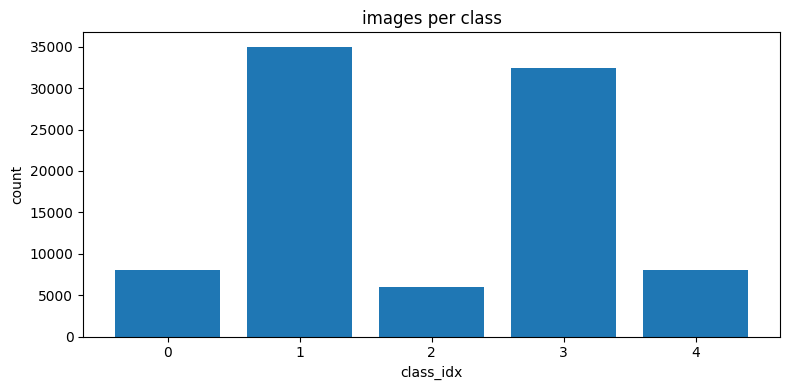

In [34]:
# --- Quick EDA: class counts ---
counts = df["class_idx"].value_counts().sort_index()
plt.figure(figsize=(8, 4))
plt.bar(counts.index.astype(str), counts.values)
plt.title("images per class")
plt.xlabel("class_idx")
plt.ylabel("count")
plt.tight_layout()
plt.show()

# --- Show image grid (corrected colors & alpha handling) ---
def show_grid(paths, cols=16, scale=2, swap_rb=True, composite_on_white=True):
    """
    paths: iterable of image file paths
    swap_rb: if True, swaps red and blue channels to fix BGR-saved assets
    composite_on_white: composites RGBA over white to avoid odd alpha/palette effects
    """
    paths = list(paths)
    rows = (len(paths) + cols - 1) // cols
    plt.figure(figsize=(cols * scale, rows * scale))

    for i, p in enumerate(paths):
        ax = plt.subplot(rows, cols, i + 1)
        ax.axis("off")
        with Image.open(p) as im:
            # normalize orientation from EXIF
            im = ImageOps.exif_transpose(im)
            # force RGBA for consistent handling of P/LA modes
            im = im.convert("RGBA")
            if composite_on_white:
                bg = Image.new("RGBA", im.size, (255, 255, 255, 255))
                im = Image.alpha_composite(bg, im)

            arr = np.asarray(im, dtype=np.uint8)[..., :3]  # drop alpha

            # Fix common OpenCV BGR-save issue
            if swap_rb:
                arr = arr[..., [2, 1, 0]]

            ax.imshow(arr, interpolation="nearest")

    plt.tight_layout()
    plt.show()



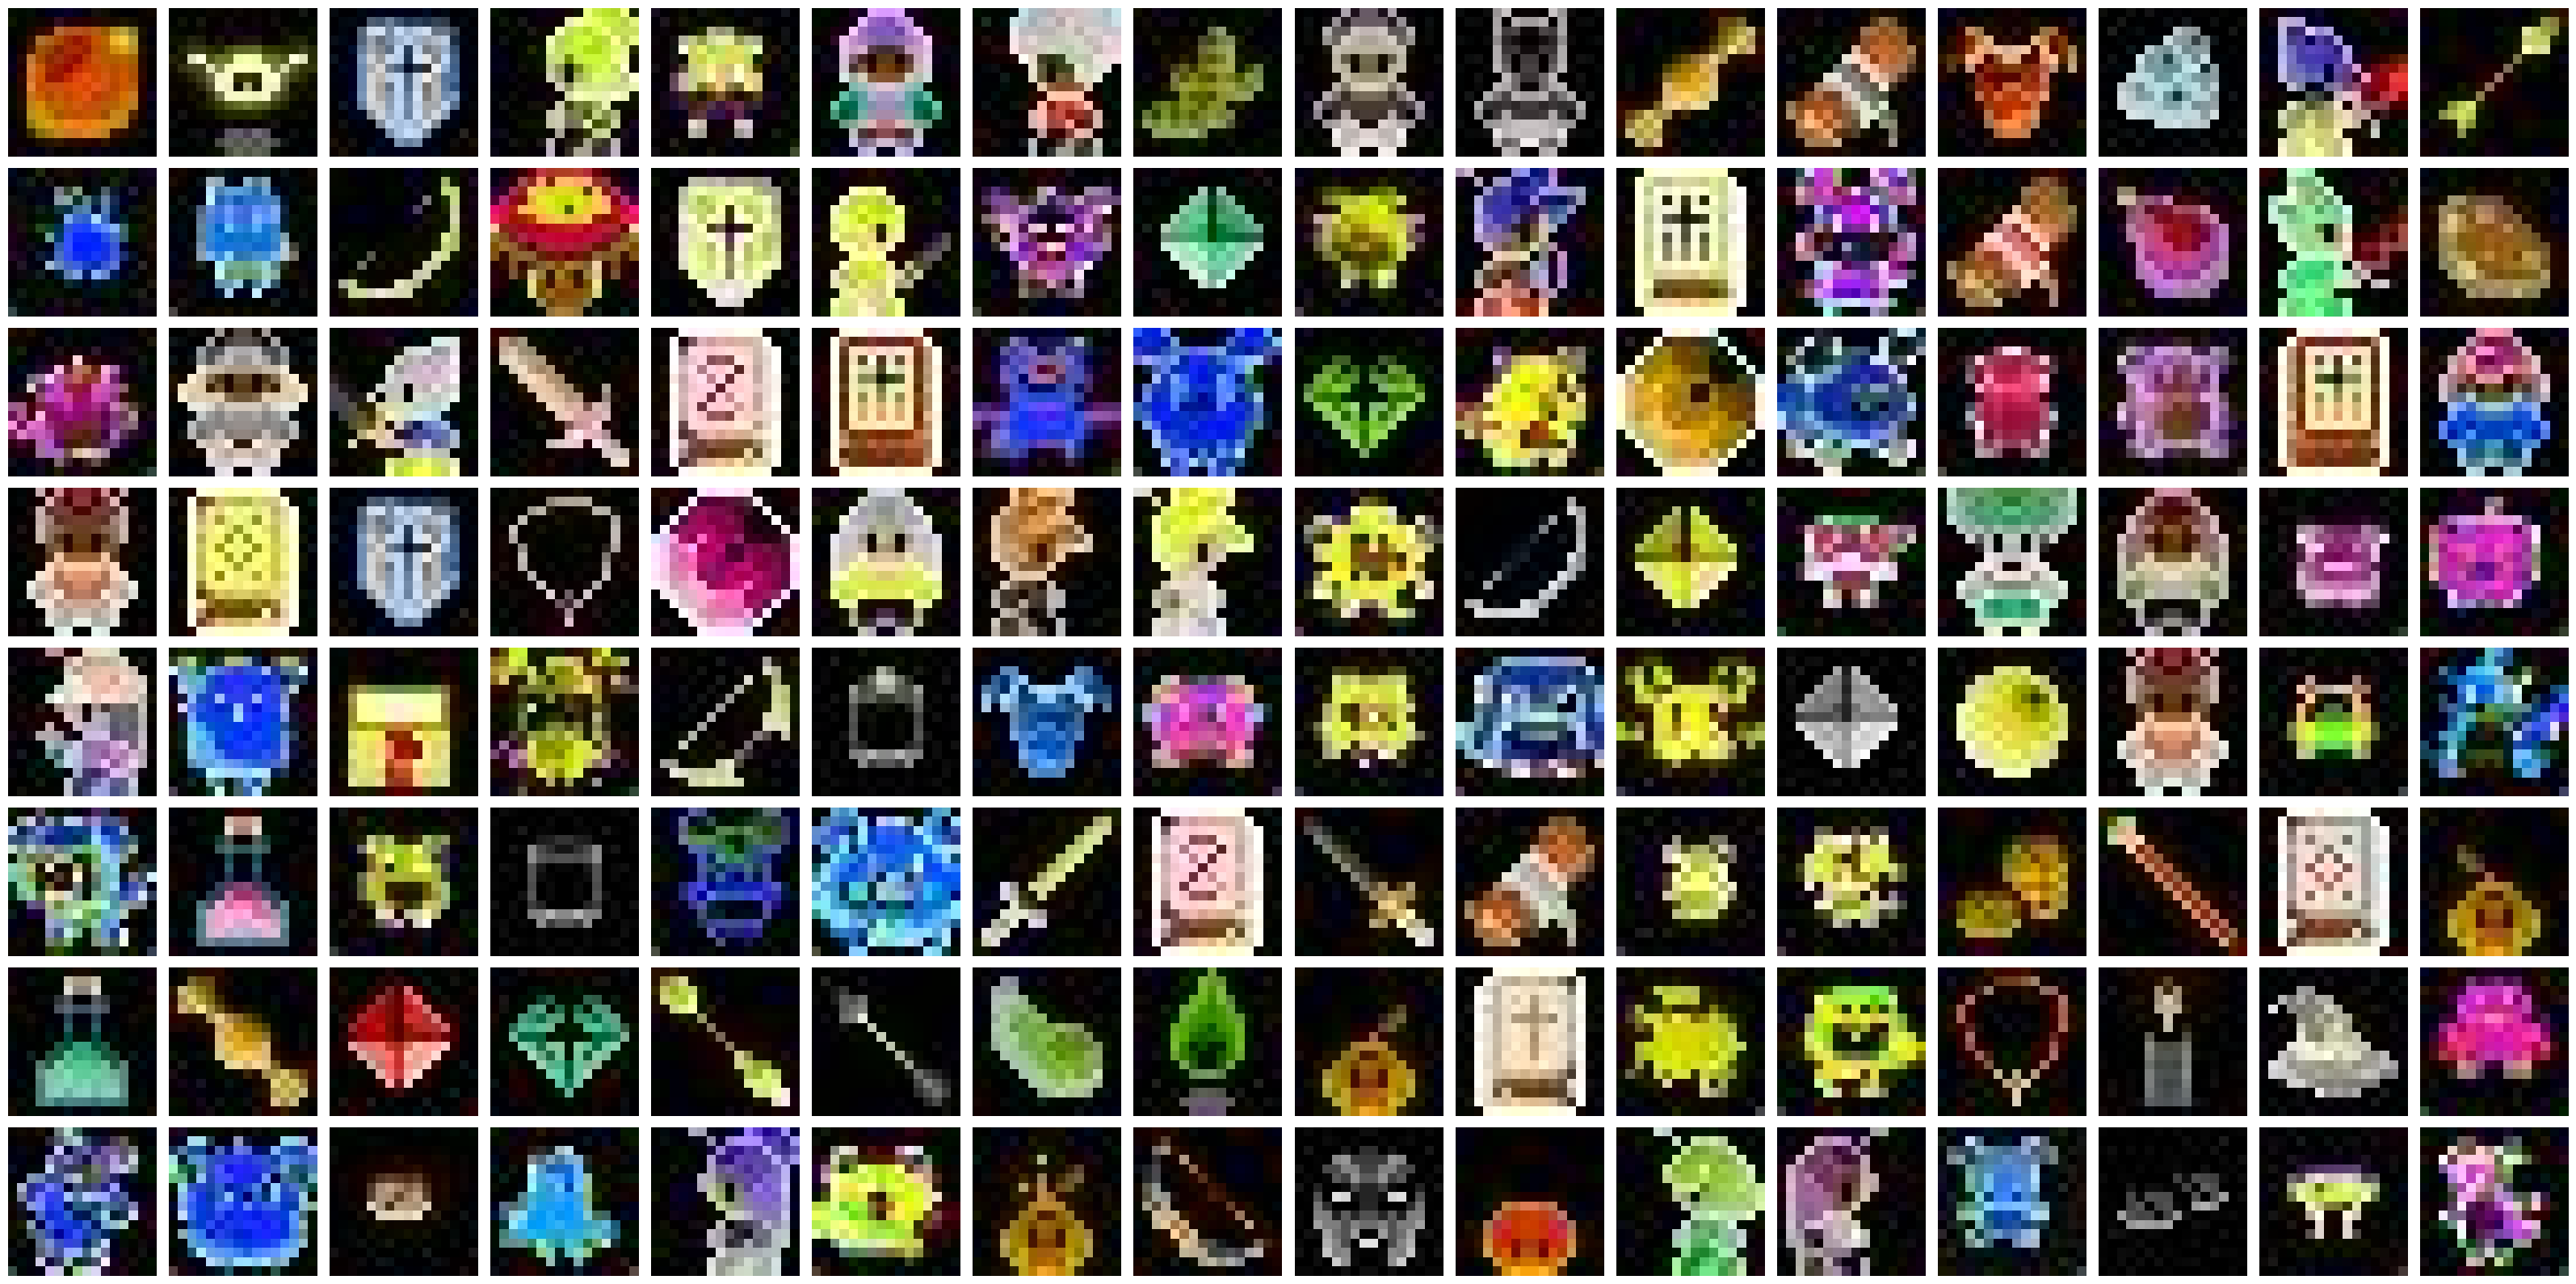

In [35]:
# visualize a sample of images
show_grid(
    df["path"].sample(min(128, len(df)), random_state=0),
    cols=16,
    scale=2,
    swap_rb=True,            # set False if your images were NOT saved from OpenCV/BGR
    composite_on_white=True  # set False if you want to preserve transparent backgrounds
)
